In [1]:
from xgboost import XGBClassifier

#required packages
import sys
sys.path.insert(0, '../scripts/')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import chardet
import datetime

import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score

from models import AE, BaselineNet
from utils import *
from xgboost import plot_importance
import xgboost as xgb

In [2]:
xgb.__version__

'1.4.1'

In [3]:
def print_results(model):
    print('Train set accuracy: {}'.format(model.score(X_train, y_train)))
    print('Test set accuracy: {}'.format(model.score(X_test, y_test)))

    return model.score(X_train, y_train), model.score(X_test, y_test)

In [22]:
df = pd.read_csv('../data/denver_prop_with_ct_clean.csv')

In [23]:
df = df.astype({
  'list_date': 'datetime64[ns]',
  'sale_date': 'datetime64[ns]'
})
# df = df.drop(columns=['rex_property_id'])

In [6]:
res = gen_dataset(df, '2019-04-01', 90)

{'bool': ['CONDO', 'MULTI_FAMILY', 'OTHER', 'SINGLE', 'has_central_air', 'has_jacuzzi', 'has_pool', 'has_solar', 'has_garage'], 'int64': ['lotsizeacres', 'lotsizesqft', 'assdtotalvalue', 'markettotalvalue', 'marketvalueland', 'marketvalueimprovement', 'bedrooms', 'totalrooms', 'bathfull', 'mean_household_income'], 'float64': ['bathtotalcalc', 'median_rental_price', 'average_annual_rent_as_percentage_of_property_value', 'farm_score', 'pop_density', 'urban_score', 'rural_score', 'built 1995 or later', 'built 1970-1994', 'built 1940-1969', 'built before 1940', 'single_family_detached_pct', 'rowhouses_and_attached_homes_pct', 'small_apt_buildings_pct', 'complexes/high_rise_apt_pct', 'mobile_home_pct', 'rental_rate', 'seasonal_housing_pct', 'vacant_homes_pct', 'family_friendly_score', 'first_time_homebuyer_score', 'luxury_communities_score', 'retirement_friendly_score', 'young_single_professional_score', 'college_student_friendly_score', 'property_crime_rate', 'standardized_test_score_perce

In [7]:
X = res['X']
y = res['y']

In [8]:
X

,bathtotalcalc,median_rental_price,average_annual_rent_as_percentage_of_property_value,farm_score,pop_density,urban_score,rural_score,built 1995 or later,built 1970-1994,built 1940-1969,...,lotsizeacres,lotsizesqft,assdtotalvalue,markettotalvalue,marketvalueland,marketvalueimprovement,bedrooms,totalrooms,bathfull,mean_household_income
1,3.5,2672.0,8.331314,100.0,5944.113744,2.0,68.0,80.577849,18.780096,0.642055,...,123,5358,29609,414100,133000,281100,4,0,3,107073
3,3.5,2672.0,8.331314,100.0,5944.113744,2.0,68.0,80.577849,18.780096,0.642055,...,123,5358,29609,414100,133000,281100,4,0,3,107073
13,2.5,2672.0,8.331314,100.0,5944.113744,2.0,68.0,80.577849,18.780096,0.642055,...,90,3920,22129,309500,80000,229500,3,0,2,107073
23,4.5,2672.0,8.331314,100.0,5944.113744,2.0,68.0,80.577849,18.780096,0.642055,...,155,6752,29280,409500,133000,276500,4,0,4,107073
28,4.5,2672.0,8.331314,100.0,5944.113744,2.0,68.0,80.577849,18.780096,0.642055,...,264,11500,31482,440300,105000,335300,4,0,4,107073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277540,4.0,3119.0,7.461027,100.0,164.477327,62.0,8.0,12.979351,81.710914,4.719764,...,35068,1527562,607750,8500000,772882,7727118,11,30,14,127096
277542,2.0,2203.0,10.072085,100.0,820.952275,51.0,19.0,86.148238,12.758202,1.093560,...,200,8712,20240,283072,74000,209072,3,6,2,61814
277549,3.5,1821.0,4.200747,0.0,111.711091,64.0,6.0,40.666667,46.833333,3.444444,...,214,9322,42050,588049,180000,408049,4,0,4,118127
277550,4.5,2146.0,4.417766,100.0,34.668743,72.0,2.0,27.410359,57.131474,11.713147,...,5380,234353,50830,710864,233564,477300,4,17,1,112043


In [9]:
X = X.rename(columns={'<18': 'less_than_18'})
X[res['bool']] = X[res['bool']]*1

In [10]:
#attempt kmeans clustering
#unsupervised approach
K = 5
init_clustering = KMeans(n_clusters=K, random_state=0).fit(X)

In [11]:
cluster_labels = init_clustering.labels_
for k in range(K):
    print('Submarket {}: {} units'.format(k, sum(cluster_labels == k)))

Submarket 0: 5338 units
Submarket 1: 13 units
Submarket 2: 484 units
Submarket 3: 1 units
Submarket 4: 36500 units


In [12]:
X['labels'] = cluster_labels 

In [13]:
train_test_dict = {}

#for loop which extracts the X & y df for each cluster
#these will then be used to run the logistic regression 
for i in range(5):
    X2 = X[X['labels'] == i]
    if X2.shape[0] < 100:
        continue
    X2 = X2.drop(columns = 'labels')
    y2 = y[X['labels'] == i]
    X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.33, random_state=297)

    train_test_dict[f'cluster {i}'] = (X_train, X_test, y_train, y_test)

/home/namluu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/namluu/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For cluster 0
Train set accuracy: 0.7418903803131991
Test set accuracy: 0.7395005675368899
Number of Homes: 1762
Expected #Sales: 457.0
Actual #Sales: 459

[14:42:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/namluu/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


XGBoost score 0.8132803632236095

gain score
['totalrooms', 'MULTI_FAMILY', 'bathfull', 'annual_births_per_resident', 'mobile_home_pct', '18-59', 'built 1995 or later', 'sqft', 'standardized_test_score_percentile', 'pct_pop_at_least_college_degree']


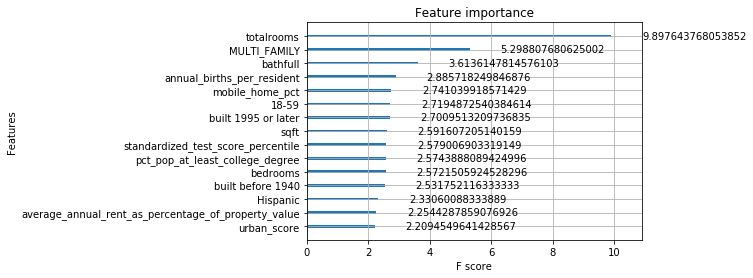

/home/namluu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/namluu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/namluu/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remov

For cluster 2
Train set accuracy: 0.8549382716049383
Test set accuracy: 0.81875
Number of Homes: 160
Expected #Sales: 29.0
Actual #Sales: 30

[14:42:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost score 0.86875

gain score
['mean_household_income', 'standardized_test_score_percentile', 'totalrooms', 'small_apt_buildings_pct', 'property_crime_rate', 'luxury_communities_score', 'bedrooms', 'bathtotalcalc', 'average_annual_rent_as_percentage_of_property_value', 'sqft']


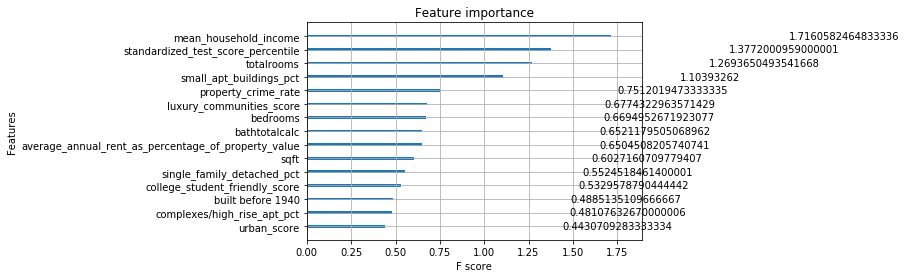

/home/namluu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/namluu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/namluu/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remov

For cluster 4
Train set accuracy: 0.6121856471069311
Test set accuracy: 0.6039850560398505
Number of Homes: 12045
Expected #Sales: 4650.0
Actual #Sales: 4742

[14:42:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/namluu/anaconda3/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


XGBoost score 0.7491905354919054

gain score
['totalrooms', 'MULTI_FAMILY', 'bathfull', 'OTHER', 'farm_score', 'luxury_communities_score', 'CONDO', 'property_crime_rate', 'White', 'lotsizesqft']


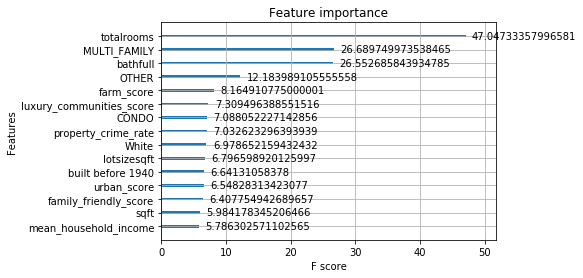

In [14]:
#now to fit for each cluster and get final results

results_dict = {}

train_acc_agg = 0
train_size = 0
test_acc_agg = 0
test_expsales_agg = 0
test_sales_agg = 0
test_size = 0

test = np.array([])
pred = np.array([])
features = set()

for i in range(5):
    if f'cluster {i}' not in train_test_dict:
        continue
        
    logit_reg = LogisticRegression()
    X_train = train_test_dict[f'cluster {i}'][0]
    X_test = train_test_dict[f'cluster {i}'][1]
    y_train = train_test_dict[f'cluster {i}'][2]
    y_test = train_test_dict[f'cluster {i}'][3]

    #fit the logistic regression to each cluster
    logit_reg.fit(X_train, y_train)
    
    #the below code is used in order to create a df containing a breakdown of metrics
    #on a per cluster basis
    print(f'For cluster {i}')
    train_accuracy, test_accuracy = print_results(logit_reg)
    exp_sales = sum(logit_reg.predict_proba(X_test)[:,1])
    actual_sales = sum(y_test[:,0])
    
    print("Number of Homes: {}".format(len(y_test)))
    print("Expected #Sales: {}".format(round(exp_sales)))
    print("Actual #Sales: {}\n".format(actual_sales))
    print('=======')

    pred_k = logit_reg.predict(X_test)
    AUC_score = roc_auc_score(y_test, pred_k)

    results_dict[f'cluster {i}'] = [train_accuracy, test_accuracy, AUC_score, round(exp_sales),actual_sales]
    
    #the below code is used to find the weighted average
    test = np.append(test,y_test)
    pred = np.append(pred,pred_k)
    train_size += len(y_train)
    train_acc_agg += train_accuracy * len(y_train)
    test_size += len(y_test)
    test_acc_agg += test_accuracy * len(y_test)
    test_expsales_agg += round(exp_sales)
    test_sales_agg += actual_sales
    
    # fit xgboost to find feature importance
    xgb_clf = XGBClassifier()
    xgb_clf.fit(X_train, y_train[:,0])
    xgbscore = xgb_clf.score(X_test, y_test[:,0])
    print('XGBoost score {}\n'.format(xgbscore))
    
    gain_score = xgb_clf.get_booster().get_score(importance_type='gain')
    sorted_gain_score = sorted(gain_score, key=gain_score.get, reverse=True)
    
    print('gain score')
    print(sorted_gain_score[:10])
    
#     results=pd.DataFrame()
#     results['columns']=X_train.columns
#     results['importances'] = xgb_clf.get_booster().get_score(importance_type='gain')
#     results.sort_values(by='importances',ascending=False,inplace=True)
    
#     print(results[:10])?
    features.update(sorted_gain_score[:7])
    
    plot_importance(xgb_clf, max_num_features=15, importance_type='gain') # top 10 most important features
    plt.show()
    
results_df = pd.DataFrame.from_dict(results_dict, orient='index')

In [15]:
results_df = results_df.rename(columns = {0:'train_accuracy', 1:'test_accuracy', 2:'Test_AUC', 3:'expec sales', 4:'actual sales'})
results_df

,train_accuracy,test_accuracy,Test_AUC,expec sales,actual sales
cluster 0,0.741890,0.739501,0.500706,457.0,459
cluster 2,0.854938,0.818750,0.516667,29.0,30
cluster 4,0.612186,0.603985,0.501152,4650.0,4742


In [16]:
print(features)

{'18-59', 'mean_household_income', 'built 1995 or later', 'OTHER', 'mobile_home_pct', 'annual_births_per_resident', 'farm_score', 'luxury_communities_score', 'totalrooms', 'CONDO', 'property_crime_rate', 'bathfull', 'small_apt_buildings_pct', 'standardized_test_score_percentile', 'MULTI_FAMILY', 'bedrooms'}


In [17]:
feature_list = list(features)

In [18]:
feature_list.extend(['list_date', 'sale_date', 'rex_property_id'])

In [25]:
print(feature_list)

['18-59', 'mean_household_income', 'built 1995 or later', 'OTHER', 'mobile_home_pct', 'annual_births_per_resident', 'farm_score', 'luxury_communities_score', 'totalrooms', 'CONDO', 'property_crime_rate', 'bathfull', 'small_apt_buildings_pct', 'standardized_test_score_percentile', 'MULTI_FAMILY', 'bedrooms', 'list_date', 'sale_date', 'rex_property_id']


In [26]:
df_small = df[feature_list].copy()

In [27]:
df_small.to_csv('../data/denver_prop_with_ct_clean_small.csv', index=False)

In [28]:
df_small

,18-59,mean_household_income,built 1995 or later,OTHER,mobile_home_pct,annual_births_per_resident,farm_score,luxury_communities_score,totalrooms,CONDO,property_crime_rate,bathfull,small_apt_buildings_pct,standardized_test_score_percentile,MULTI_FAMILY,bedrooms,list_date,sale_date,rex_property_id
0,0.616287,107073,80.577849,False,0.000000,0.016527,100.0,21.852379,0,False,11.972931,3,0.802568,81.596980,False,4,2016-06-30,2016-08-12,207973152
1,0.616287,107073,80.577849,False,0.000000,0.016527,100.0,21.852379,0,False,11.972931,3,0.802568,81.596980,False,4,2019-04-26,2019-05-29,207973152
2,0.616287,107073,80.577849,False,0.000000,0.016527,100.0,21.852379,0,False,11.972931,3,0.802568,81.596980,False,4,2016-06-30,2016-08-12,207973152
3,0.616287,107073,80.577849,False,0.000000,0.016527,100.0,21.852379,0,False,11.972931,3,0.802568,81.596980,False,4,2019-04-26,2019-05-29,207973152
4,0.616287,107073,80.577849,False,0.000000,0.016527,100.0,21.852379,16,False,11.972931,2,0.802568,81.596980,False,5,2020-06-26,2020-08-10,208397574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277547,0.623831,108207,3.015682,False,0.422195,0.016525,100.0,16.930720,5,True,19.415404,2,0.000000,81.854093,False,2,2018-05-18,2018-06-28,352759060
277548,0.541232,78117,22.450889,False,8.840037,0.018905,0.0,50.545896,9,False,0.000000,1,5.051450,42.274687,False,3,2020-09-08,2100-01-01,121948410
277549,0.519823,118127,40.666667,False,9.638889,0.008756,0.0,26.129220,0,False,8.233059,4,0.527778,74.072710,False,4,2017-05-31,2100-01-01,122775824
277550,0.511367,112043,27.410359,False,2.788845,0.009153,100.0,25.255845,17,False,11.689526,1,0.876494,60.597145,False,4,2017-06-02,2100-01-01,93936156


In [29]:
res = gen_dataset(df_small, '2017-04-01', 90)

{'bool': ['OTHER', 'CONDO', 'MULTI_FAMILY'], 'int64': ['mean_household_income', 'totalrooms', 'bathfull', 'bedrooms', 'rex_property_id'], 'float64': ['18-59', 'built 1995 or later', 'mobile_home_pct', 'annual_births_per_resident', 'farm_score', 'luxury_communities_score', 'property_crime_rate', 'small_apt_buildings_pct', 'standardized_test_score_percentile'], 'datetime64[ns]': ['list_date', 'sale_date']}


In [30]:
res['X']

,18-59,built 1995 or later,mobile_home_pct,annual_births_per_resident,farm_score,luxury_communities_score,property_crime_rate,small_apt_buildings_pct,standardized_test_score_percentile,OTHER,CONDO,MULTI_FAMILY,mean_household_income,totalrooms,bathfull,bedrooms,rex_property_id
5,0.616287,80.577849,0.000000,0.016527,100.0,21.852379,11.972931,0.802568,81.596980,False,False,False,107073,0,3,3,207998741
6,0.616287,80.577849,0.000000,0.016527,100.0,21.852379,11.972931,0.802568,81.596980,False,False,False,107073,0,4,4,207964420
10,0.616287,80.577849,0.000000,0.016527,100.0,21.852379,11.972931,0.802568,81.596980,False,True,False,107073,0,2,3,208988684
24,0.616287,80.577849,0.000000,0.016527,100.0,21.852379,11.972931,0.802568,81.596980,False,False,False,107073,0,3,3,207945896
45,0.616287,80.577849,0.000000,0.016527,100.0,21.852379,11.972931,0.802568,81.596980,False,False,False,107073,0,4,4,209014795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277543,0.576851,33.745875,72.689769,0.008435,50.0,83.660109,30.618140,0.000000,16.884993,False,False,False,55974,6,3,3,351207667
277544,0.623831,3.015682,0.422195,0.016525,100.0,16.930720,19.415404,0.000000,81.854093,False,True,False,108207,5,2,2,352759060
277546,0.623831,3.015682,0.422195,0.016525,100.0,16.930720,19.415404,0.000000,81.854093,False,True,False,108207,5,2,2,352759060
277549,0.519823,40.666667,9.638889,0.008756,0.0,26.129220,8.233059,0.527778,74.072710,False,False,False,118127,0,4,4,122775824


In [ ]:
res['X']

In [21]:
df

,lotsizeacres,lotsizesqft,assdtotalvalue,markettotalvalue,marketvalueland,marketvalueimprovement,bedrooms,totalrooms,bathtotalcalc,bathfull,...,OTHER,SINGLE,list_date,sale_date,sqft,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage
0,123,5358,29609,414100,133000,281100,4,0,3.5,3,...,False,True,2016-06-30,2016-08-12,1708.0,False,False,False,False,False
1,123,5358,29609,414100,133000,281100,4,0,3.5,3,...,False,True,2019-04-26,2019-05-29,1708.0,False,False,False,False,False
2,123,5358,29609,414100,133000,281100,4,0,3.5,3,...,False,True,2016-06-30,2016-08-12,1708.0,False,False,False,False,False
3,123,5358,29609,414100,133000,281100,4,0,3.5,3,...,False,True,2019-04-26,2019-05-29,1708.0,False,False,False,False,False
4,200,8712,33126,463300,110000,353300,5,16,3.5,2,...,False,True,2020-06-26,2020-08-10,2988.0,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277547,86,3746,27400,383228,78000,305228,2,5,2.0,2,...,False,False,2018-05-18,2018-06-28,1424.0,False,False,False,False,False
277548,201,8756,21190,296330,45000,251330,3,9,3.0,1,...,False,True,2020-09-08,2100-01-01,1570.0,False,False,False,False,True
277549,214,9322,42050,588049,180000,408049,4,0,3.5,4,...,False,True,2017-05-31,2100-01-01,3169.0,False,False,False,False,False
277550,5380,234353,50830,710864,233564,477300,4,17,4.5,1,...,False,True,2017-06-02,2100-01-01,2208.0,False,False,False,False,False


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1c850c61-d934-4c85-b16d-3cb283df0c84' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>